```Good morning, gent!
The year is 1945. The British forces are about to wipe out the Nazis, once and for all.
You are a young enthusiast meteorologist, and you are about to give the Great British Empire its victory!
At your disposal is the Royal Dataset of Measurements from forecasting stations around the globe. Measurements are taken each morning and each noon. Since we are British, we don't believe in surprise attacks. Leave that rubbish for the barbarians. Instead, we spend each morning preparing for the battle, and attack the bloody Nazis by noon, like gentlemen. Hence, it is of utter importance that you can forecast the temperatures at noon each day.
Are you ready for the mission? Are you ready to destroy the Nazis?```

```~Ittai Haran```

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

```Start by reading the Royal Dataset of Measurements. Also at your disposal is the data_weather_station_locations dataset. As a former meteorologist myself, I suggest you merge it into your measurements dataset.
Split your data properly (remember that the British army wants to keep its time travel abilities in secret for a little longer). Split it such that you have 70% of the data in your training segment.
Do you have missing values in your dataset? or any categorical values? deal with them with care.```

In [2]:
from collections import Counter
df = pd.read_csv('data/Royal_Dataset_of_Measurements.csv').merge(pd.read_csv('data/data_weather_station_locations.csv'), on='STA', how='left').drop('STA', axis=1)
change_state = {v[0]:k for k,v in enumerate(Counter(df['STATE/COUNTRY ID']).most_common())}
df['STATE/COUNTRY ID'] = df['STATE/COUNTRY ID'].apply(change_state.get)

df = df.sort_values('Date')
X = df.drop(['MiddayTemp', 'Date'], axis=1).fillna(0)
Y = df['MiddayTemp']
X_train = X.iloc[:int(len(df)*0.7)]
X_test = X.iloc[int(len(df)*0.7):]
Y_train = Y.iloc[:int(len(df)*0.7)]
Y_test = Y.iloc[int(len(df)*0.7):]

```Just for warmup: where are the forecasting stations? Show them all on a single map, using your favorite tools. There are rumors about this sophisticated tool called "Google" that can help you do it.```

In [31]:
import folium
 
data = pd.DataFrame({
'lat':list(places['Latitude']),
'lon':list(places['Longitude']),
'name':list(places['STATE/COUNTRY ID'])
})
 
m = folium.Map(location=[20, 0], tiles="OpenStreetMap", zoom_start=2)
 
for i in range(0,len(data)):
    folium.Marker([data.iloc[i]['lon'], data.iloc[i]['lat']], popup=data.iloc[i]['name']).add_to(m)
m


```I'm told that you need a definition for a loss function. well, I'm not such a technologist myself, but I can tell you that your loss should be linear in the absolute value of your error.
A friend from the Royal Navy once told me, "Aye stairt wi' a guid auld xgboost". I trust this friend, and you should too. What results did you get?```

In [4]:
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
model = XGBRegressor()
model.fit(X_train, Y_train)

print(mean_absolute_error(Y_train, model.predict(X_train)))
print(mean_absolute_error(Y_test, model.predict(X_test)))

667742.4990057555
475481.0731915111


```Heavens in the sky, that's not so good. This bloody scot, I never trusted him.
Let's try a different approach. Another friend, from the Royal Airforce, told me, "When you are preplexed and can't find your arms and legs, try training a neural net and look carefully at its loss".
I trust this friend very much. You should try what he suggested. Can you learn something to explains our poor results from earlier? Don't forget - neural networks work better when first normalizing your data.```

In [6]:
from sklearn.preprocessing import StandardScaler
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

In [235]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.initializers import Constant

main_input = Input((12,))
hidden = Dense(20, activation='tanh')(main_input)
hidden = Dense(20, activation='tanh')(hidden)
hidden = Dense(15, activation='tanh')(hidden)
hidden = Dense(10, activation='tanh')(hidden)
hidden = Dense(5, activation='tanh')(hidden)
main_output = Dense(1, activation='linear')(hidden)

model = Model(inputs=[main_input], outputs=[main_output])
model.compile(optimizer='adam', loss='mae')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_92 (InputLayer)        (None, 12)                0         
_________________________________________________________________
dense_277 (Dense)            (None, 20)                260       
_________________________________________________________________
dense_278 (Dense)            (None, 20)                420       
_________________________________________________________________
dense_279 (Dense)            (None, 15)                315       
_________________________________________________________________
dense_280 (Dense)            (None, 10)                160       
_________________________________________________________________
dense_281 (Dense)            (None, 5)                 55        
_________________________________________________________________
dense_282 (Dense)            (None, 1)                 6         
Total para

In [51]:
model.fit(X_train_scaled, Y_train, batch_size=30, epochs=10)

Epoch 1/10
83328/83328 [==============================] - 3s 39us/step - loss: 120025.0950
Epoch 2/10
13890/83328 [====>.........................] - ETA: 2s - loss: 9.9682 

KeyboardInterrupt: 

```As I suspected.. The wanker Nazis must have poisoned our dataset! Intel tells me that they could insert one sample at most. Find it and delete it from our Royal Dataset.```

In [7]:
df = df.drop(df.iloc[np.argmax(df['MiddayTemp'].values)].name)
df = df.sort_values('Date')
X = df.drop(['MiddayTemp', 'Date'], axis=1).fillna(0)
Y = df['MiddayTemp']
X_train = X.iloc[:int(len(df)*0.7)]
X_test = X.iloc[int(len(df)*0.7):]
Y_train = Y.iloc[:int(len(df)*0.7)]
Y_test = Y.iloc[int(len(df)*0.7):]

scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

```Blinding. Now train your xgboost and neural network again! What results can you get?
Let me drop another tip for you: when you have an idea of the mean of the target you try to predict, you can initiate the last layer's bias to be this mean. It can make your network converge so much faster!```

In [8]:
model = XGBRegressor()
model.fit(X_train, Y_train)

print(mean_absolute_error(Y_train, model.predict(X_train)))
print(mean_absolute_error(Y_test, model.predict(X_test)))

1.8015172255440222
2.088446662416681


```I've got a new message from Bletchley. Apperantly, our troops are very sensitive to cold weather, but to warm weather? not so much. We should update our loss function accordingly. They gave me this formula, that I myself can't read, but you might:```

$\frac {\sum_i {|Pred_i-True_i|}}{\sum_i {Pred_i}}$

```Does it do what we want it to do? Are there any visible problems with this loss? List here all the problems that come to your mind, regarding this loss. Assuming you have only one sample in your dataset, draw the loss as a function of your prediction. Also, evaluate your former models using this metric.```

In [9]:
import keras.backend as K
from keras.losses import MSE

def funny_metric(y_true, y_pred):
    if isinstance(y_pred, pd.DataFrame) or isinstance(y_pred, pd.Series):
        y_pred = y_pred.values
    if isinstance(y_true, pd.DataFrame) or isinstance(y_true, pd.Series):
        y_true = y_true.values
    return np.sum(np.abs(y_true.reshape(-1)-y_pred.reshape(-1)))/float(np.sum(y_pred.reshape(-1)))


def custom_loss(y_true, y_pred):
    return K.sum(K.abs(y_true-y_pred))/K.sum(y_pred)


C:\Users\MMM\AppData\Local\conda\conda\envs\python3_ittai\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


C:\Users\MMM\AppData\Local\conda\conda\envs\python3_ittai\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


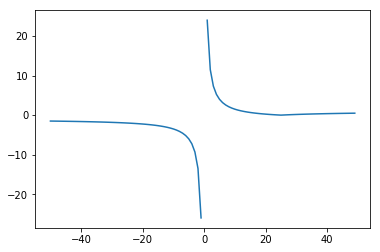

In [10]:
true_val = 25
vec = np.arange(-50,50,1)
plt.plot(vec, np.abs(vec-true_val)/vec)
plt.show()

```That loss function seems a bit suspicious. Let's have a closer look. Implement it (for batches - why can't you properly train a sgd on this loss?), and see if the network exhibits reasonal behavior.
The British people take pride for their meticulous examinations of networks. What happens if the network decides, for some reason, to predict negative values? Try train a network that initializes to predict negative values (maybe change the last bias again). Can you understand the behavior of the loss during training?```

```Compare neural networks trained with this special loss, with MSE and with MAE. Which one achieves the best MAE loss? which one achieves the best special loss?```

```Iv'e just got an urgent message from the field marshal! He told me, "Hoi, gent, my soldiers are cold! I have soldiers all around this damned globe, spread evenly, but you keep my boys worm only in a few damned countries!". Do you think the field marchel is right? Why is that? Can you change the loss function to take this effect into account (bonus points if you can write it in LaTex)? Train a network using this loss.```

In [230]:
from keras.layers import Input, Dense, Concatenate, Reshape, Lambda, Flatten
from keras.models import Model
from keras.initializers import Constant

NUMBER_OF_COUNTRIES = len(set(df['STATE/COUNTRY ID']))
X_train['STATE/COUNTRY ID']
weights = 1/np.array(list(Counter(df['STATE/COUNTRY ID']).values()))
weights = weights/np.sum(weights)
weights_tensor = K.variable(weights.reshape(1,-1))

def carefull_eval(y_true, y_pred, classes):
    num = np.abs(y_true - y_pred).reshape(-1,1)
    one_hot = np.eye(NUMBER_OF_COUNTRIES)[classes]
    return np.sum(weights*np.sum(one_hot*num, axis=0)/(np.sum(one_hot*y_pred.reshape(-1,1), axis=0)+1e-8))

def custom_loss_with_rel(y_true, y_pred_con):
    num = K.abs(y_true-y_pred_con[:,:1])
    dum = y_pred_con[:,:1]
    one_hot_rep = K.one_hot(K.cast(y_pred_con[:,1:], 'int32'), NUMBER_OF_COUNTRIES)
    one_hot_rep = K.reshape(one_hot_rep, (K.shape(one_hot_rep)[0],NUMBER_OF_COUNTRIES))
    return K.sum(weights_tensor*(K.sum(one_hot_rep*num, axis=0) / (K.sum(one_hot_rep*dum, axis=0)+1e-8)))

def custom_loss(y_true, y_pred):
    return K.sum(K.abs(y_true-y_pred))/K.sum(y_pred)

main_input = Input((12,))
hidden = Dense(20, activation='tanh')(main_input)
hidden = Dense(20, activation='tanh')(hidden)
hidden = Dense(15, activation='tanh')(hidden)
hidden = Dense(10, activation='tanh')(hidden)
hidden = Dense(5, activation='tanh')(hidden)

main_output = Dense(1, activation='linear', bias_initializer=Constant(np.mean(Y_train)))(hidden)

country_relevence_input = Input((1,))
total_output = Concatenate()([main_output, country_relevence_input])

predict_model = Model(inputs=[main_input], outputs=[main_output])
model = Model(inputs=[main_input, country_relevence_input], outputs=[total_output])
model.compile(optimizer='adam', loss=custom_loss_with_rel)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_90 (InputLayer)           (None, 12)           0                                            
__________________________________________________________________________________________________
dense_271 (Dense)               (None, 20)           260         input_90[0][0]                   
__________________________________________________________________________________________________
dense_272 (Dense)               (None, 20)           420         dense_271[0][0]                  
__________________________________________________________________________________________________
dense_273 (Dense)               (None, 15)           315         dense_272[0][0]                  
__________________________________________________________________________________________________
dense_274 

In [231]:
print(carefull_eval(Y_train.values.reshape(-1), predict_model.predict(X_train_scaled).reshape(-1), X_train['STATE/COUNTRY ID'].values.reshape(-1)))
print(carefull_eval(Y_test.values.reshape(-1), predict_model.predict(X_test_scaled).reshape(-1), X_test['STATE/COUNTRY ID'].values.reshape(-1)))

0.10210495123649464
0.21662586464607198


In [233]:
model.fit([X_train_scaled, X_train['STATE/COUNTRY ID'].values.reshape(-1,1)], Y_train, batch_size=30, epochs=25)

Epoch 1/25
81606/81606 [==============================] - 6s 70us/step - loss: 0.0117
Epoch 2/25
81606/81606 [==============================] - 5s 61us/step - loss: 0.0096
Epoch 3/25
81606/81606 [==============================] - 5s 57us/step - loss: 0.0085
Epoch 4/25
81606/81606 [==============================] - 5s 59us/step - loss: 0.0079
Epoch 5/25
81606/81606 [==============================] - 5s 62us/step - loss: 0.0074
Epoch 6/25
81606/81606 [==============================] - 5s 62us/step - loss: 0.0071
Epoch 7/25
81606/81606 [==============================] - 5s 61us/step - loss: 0.0069
Epoch 8/25
81606/81606 [==============================] - 5s 64us/step - loss: 0.0067
Epoch 9/25
81606/81606 [==============================] - 5s 64us/step - loss: 0.0065
Epoch 10/25
81606/81606 [==============================] - 5s 60us/step - loss: 0.0064
Epoch 11/25
81606/81606 [==============================] - 5s 62us/step - loss: 0.0063
Epoch 12/25
81606/81606 [===========================

In [234]:
print(carefull_eval(Y_train.values.reshape(-1), predict_model.predict(X_train_scaled).reshape(-1), X_train['STATE/COUNTRY ID'].values.reshape(-1)))
print(carefull_eval(Y_test.values.reshape(-1), predict_model.predict(X_test_scaled).reshape(-1), X_test['STATE/COUNTRY ID'].values.reshape(-1)))

0.035474795107932666
0.15786419593957113


```Something here smells fhisy as a drunk french on sunday morning. Try comparing the network you trained using the new loss with the other networks you trained so far, using all the metrics we used so far. What results did you get? Can you explain your results?```

```Train the best model you can to answer for the field marchel's needs and win the war!```